In [1]:
using Revise
using Bilevel
using Bilevel: VariableSelector, ConstraintSelector, add_var!, add_eq!, add_ineq!, contact_jacobian!, contact_friction_τ_direct!, contact_normal_τ_direct!, contact_friction_τ_direct_osqp!, contact_normal_τ_direct_osqp!

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using Plots
using LinearAlgebra
using StaticArrays
using ForwardDiff
using Base.Threads
using BenchmarkTools
using SparseArrays

┌ Info: Precompiling Bilevel [9688c538-179f-11e9-3174-495cea6b7f67]
└ @ Base loading.jl:1186


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

┌ Error: evaluation error
│   mod = Bilevel
│   ex = const usrfun = #= /home/blandry/.julia/dev/Bilevel/src/solvers/snopt.jl:154 =# @cfunction(objcon_wrapper, Cvoid, (Ptr{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}, Ref{Clong}, Ptr{Cdouble}, Ptr{Cchar}, Ref{Clong}, Ptr{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}))
│   exception = (ErrorException("invalid lookup expr (\$(QuoteNode(Core.svec)))(JuliaInterpreter.SSAValue(2), JuliaInterpreter.SSAValue(3), JuliaInterpreter.SSAValue(4), JuliaInterpreter.SSAValue(5), JuliaInterpreter.SSAValue(6), JuliaInterpreter.SSAValue(7), JuliaInterpreter.SSAValue(8), JuliaInterpreter.SSAValue(9), JuliaInterpreter.SSAValue(10), JuliaInterpreter.SSAValue(11), JuliaInterpreter.SSAValue(12), JuliaInterpreter.SSAValue(13), JuliaInterpreter.SSAValue(14), JuliaInterpreter.SSAValue(15), JuliaInterpreter.SSAValue(16))"), Union{Ptr{Nothing}, InterpreterIP}[Ptr{Nothing} @0x00007fa0e38965eb, Ptr{Nothing} @0x00007fa0e3867204, P

In [4]:
urdf = joinpath("..", "..", "urdf", "box2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.125)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles)

Environment(Contact[Contact(Spanning tree:
Vertex: world (root)
  Vertex: floor, Edge: floor_to_world
    Vertex: box, Edge: floor_to_box
No non-tree joints., box, Point3D in "after_floor_to_box": [-0.06, 0.0, -0.0375], Obstacle(floor, Point3D in "after_floor_to_world": [0.0, 0.0, 0.0], FreeVector3D in "after_floor_to_world": [0.0, 0.0, 1.0], [1.0 6.12323e-17 -1.0 -1.83697e-16; 0.0 1.0 1.22465e-16 -1.0; 0.0 0.0 0.0 0.0], 1.125, false)), Contact(Spanning tree:
Vertex: world (root)
  Vertex: floor, Edge: floor_to_world
    Vertex: box, Edge: floor_to_box
No non-tree joints., box, Point3D in "after_floor_to_box": [0.06, 0.0, -0.0375], Obstacle(floor, Point3D in "after_floor_to_world": [0.0, 0.0, 0.0], FreeVector3D in "after_floor_to_world": [0.0, 0.0, 1.0], [1.0 6.12323e-17 -1.0 -1.83697e-16; 0.0 1.0 1.22465e-16 -1.0; 0.0 0.0 0.0 0.0], 1.125, false))])

In [5]:
N = 10
Δt = 0.1
q0 = [0., -0.0375, 0.]
v0 = [7., 0., 0.]

sim_data = get_sim_data_indirect(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
traj = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

(Array{Float64,1}[[0.0, -0.0375, 0.0], [0.589637, -0.0375, 4.54023e-12], [1.06891, -0.0375, -2.00551e-17], [1.43782, -0.0375, 3.26688e-17], [1.69637, -0.0375, -2.64179e-17], [1.84456, -0.0375, -2.54638e-17], [1.88239, -0.0375, 2.22809e-17], [1.88239, -0.0375, -1.11286e-11], [1.88239, -0.0375, -2.16111e-12], [1.88239, -0.0375, -2.16111e-12]], Array{Float64,1}[[7.0, 0.0, 0.0], [5.89637, -2.95113e-11, 4.54023e-11], [4.79275, 7.73623e-12, -4.54025e-11], [3.68912, 6.40265e-18, 3.26688e-16], [2.5855, -2.85691e-18, -5.90867e-16], [1.48187, 8.97065e-17, 3.36229e-16], [0.37825, -1.48795e-16, -1.1342e-16], [-4.17324e-12, -6.64518e-12, -1.11286e-10], [3.36283e-12, 5.38052e-12, 8.96749e-11], [3.36283e-12, 5.38052e-12, 8.96749e-11]], Array{Float64,1}[], Array{Array{Float64,1},1}[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[0.148438, 2.52435e-29, 0.0, 0.166992, 0.0, 5.89638], [0.851562, 0.0, 0.0, 0.958008, 0.0, 5.89637]], [[0.148437, 2.52435e-29, 0.0, 0.166992, 0.0, 4.79275], 

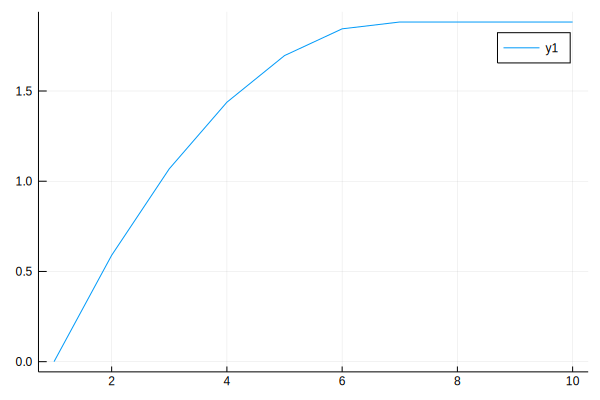

In [6]:
plot(traj[7][1,:])

In [7]:
num_pos = num_positions(mechanism)
num_vel = num_velocities(mechanism)
num_contacts = length(sim_data.env.contacts)

sample_vs = VariableSelector()
add_var!(sample_vs, :q0, num_pos)
add_var!(sample_vs, :v0, num_vel)
add_var!(sample_vs, :u0, num_vel)
add_var!(sample_vs, :qnext, num_pos)
add_var!(sample_vs, :vnext, num_vel)
add_var!(sample_vs, :h, 1)
add_var!(sample_vs, :c_n, num_contacts)

data = Array{Array{Float64,1},1}()

for n = 2:(length(traj[6])-1)
    q0 = traj[1][n]
    v0 = traj[2][n]
    u0 = zeros(num_vel)
    qnext = traj[1][n+1]
    vnext = traj[2][n+1]
    h = traj[6][n+1] - traj[6][n]
    c_n = [ traj[8][:,n][sim_data.vs(Symbol("c_n", i))][1] for i = 1:num_contacts ]
    
    sample = zeros(Float64, sample_vs.num_vars)
    sample[sample_vs(:q0)] = q0
    sample[sample_vs(:v0)] = v0
    sample[sample_vs(:u0)] = u0
    sample[sample_vs(:qnext)] = qnext
    sample[sample_vs(:vnext)] = vnext
    sample[sample_vs(:h)] = [h]
    sample[sample_vs(:c_n)] = c_n
    
    push!(data, sample)
end

In [6]:
num_samples = length(data)

sim_data = get_sim_data_direct(mechanism,env,0.01)
sim_data.fric_options[1]["num_fosteps"] = 0
sim_data.fric_options[1]["num_sosteps"] = 30
sim_data.fric_options[1]["c"] = 1
sim_data.fric_options[1]["c_fos"] = 1
sim_data.fric_options[1]["c_sos"] = 1
    
function compute_friction(;sample_range=1:num_samples)
    for i = sample_range
        sample = data[i]
        q0 = sample_vs(sample, :q0)
        v0 = sample_vs(sample, :v0)
        u0 = sample_vs(sample, :u0)
        qnext = sample_vs(sample, :qnext)
        vnext = sample_vs(sample, :vnext)
        h = sample_vs(sample, :h)[1]
        c_n = sample_vs(sample, :c_n)
        
        x0 = sim_data.state_cache[1][Float64]
        xn = sim_data.state_cache[2][Float64]
        envj = sim_data.envj_cache[2][Float64]

        set_configuration!(x0, q0)
        set_velocity!(x0, v0)
        setdirty!(x0)
        set_configuration!(xn, qnext)
        set_velocity!(xn, vnext)
        setdirty!(xn)

        normalize_configuration!(x0)
        normalize_configuration!(xn)

        H = mass_matrix(x0)
        Hi = inv(H)
        config_derivative = configuration_derivative(xn)
        dyn_bias = dynamics_bias(xn)

        contact_jacobian!(envj, xn)
        
        contact_bias = Vector{Float64}(undef, num_vel)                        
        contact_friction_τ_direct!(contact_bias, sim_data, h, Hi, envj, dyn_bias, u0, v0, zeros(Float64, 1), c_n, 1)
        display(contact_bias)
        
        contact_bias_osqp = Vector{Float64}(undef, num_vel)                        
        contact_friction_τ_direct_osqp!(sim_data, h, Hi, envj, dyn_bias, u0, v0, zeros(Float64, 1), c_n, 1)
        display(contact_bias_osqp)
    end
end

compute_friction (generic function with 1 method)

In [51]:
num_samples = length(data)

sim_data = get_sim_data_direct(mechanism,env,0.01)
sim_data.normal_options[1]["num_fosteps"] = 0
sim_data.normal_options[1]["num_sosteps"] = 20
sim_data.normal_options[1]["c"] = 1
sim_data.normal_options[1]["c_fos"] = 1
sim_data.normal_options[1]["c_sos"] = 1
sim_data.fric_options[1]["num_fosteps"] = 0
sim_data.fric_options[1]["num_sosteps"] = 10
sim_data.fric_options[1]["c"] = 1
sim_data.fric_options[1]["c_fos"] = 1
sim_data.fric_options[1]["c_sos"] = 1
    
sample = data[5]
q0 = sample_vs(sample, :q0)
v0 = sample_vs(sample, :v0)
u0 = sample_vs(sample, :u0)
qnext = sample_vs(sample, :qnext)
vnext = sample_vs(sample, :vnext)
h = sample_vs(sample, :h)[1]
c_n = sample_vs(sample, :c_n)
        
x0 = sim_data.state_cache[1][Float64]
xn = sim_data.state_cache[2][Float64]
envj = sim_data.envj_cache[2][Float64]

set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
set_configuration!(xn, qnext)
set_velocity!(xn, vnext)
setdirty!(xn)

normalize_configuration!(x0)
normalize_configuration!(xn)

H = mass_matrix(x0)
Hi = inv(H)
config_derivative = configuration_derivative(xn)
dyn_bias = dynamics_bias(xn)

contact_jacobian!(envj, xn)

normal_bias = Vector{Float64}(undef, num_vel)
contact_normal_τ_direct!(normal_bias, sim_data, h, Hi, envj, dyn_bias, u0, v0, zeros(Float64, 1), 1)
display(normal_bias)

normal_bias_osqp = Vector{Float64}(undef, num_vel)
xosqp = contact_normal_τ_direct_osqp!(normal_bias_osqp, sim_data, h, Hi, envj, dyn_bias, u0, v0, zeros(Float64, 1), 1)
display(normal_bias_osqp)

contact_bias = Vector{Float64}(undef, num_vel)                        
# display(@benchmark contact_friction_τ_direct!(contact_bias, sim_data, h, Hi, envj, dyn_bias, u0, v0, zeros(Float64, 1), c_n, 1))
contact_friction_τ_direct!(contact_bias, sim_data, h, Hi, envj, dyn_bias, u0, v0, zeros(Float64, 1), c_n, 1)
display(contact_bias)
        
contact_bias_osqp = Vector{Float64}(undef, num_vel)                        
# display(@benchmark contact_friction_τ_direct_osqp!(contact_bias_osqp, sim_data, h, Hi, envj, dyn_bias, u0, v0, zeros(Float64, 1), c_n, 1))
contact_friction_τ_direct_osqp!(contact_bias_osqp, sim_data, h, Hi, envj, dyn_bias, u0, v0, zeros(Float64, 1), c_n, 1)
display(contact_bias_osqp)

3-element Array{Float64,1}:
  4.355822361519164e-16 
 19.54962136261888      
  1.8306911542254056e-11

3-element Array{Float64,1}:
  4.354965230348981e-16 
 19.545774422031215     
 -0.00023081726300844263

3-element Array{Float64,1}:
 11.036249999806344    
  9.810000000000002    
  7.258943446331045e-12

3-element Array{Float64,1}:
 11.03612233213057    
  9.810000000000002   
  4.787545100359836e-6

## direct

In [30]:
N = 10
Δt = 0.1
q0 = [0., -0.0375, 0.]
v0 = [7., 0., 0.]

sim_data = get_sim_data_direct(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
traj = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

(Array{Float64,1}[[0.0, -0.0375, 0.0], [0.590583, -0.0366852, 6.77021e-6], [1.06991, -0.0366677, 2.04243e-5], [1.43884, -0.0366717, 4.09094e-5], [1.69741, -0.0366709, 6.82234e-5], [1.84562, -0.0366713, 0.000102366], [1.88346, -0.0366733, 0.000143338], [1.88347, -0.0366753, 0.000186651], [1.88347, -0.0366784, 0.000229965], [1.88348, -0.0366784, 0.000273279]], Array{Float64,1}[[7.0, 0.0, 0.0], [5.90583, 0.00810757, 6.77021e-5], [4.79329, 7.70884e-5, 0.000136541], [3.68932, -0.000190437, 0.000204851], [2.58568, -0.000168469, 0.00027314], [1.48208, -0.000156164, 0.000341427], [0.378399, -7.4234e-5, 0.00040972], [5.87269e-5, -3.59954e-5, 0.000433133], [5.87269e-5, -3.11794e-5, 0.000433135], [5.87269e-5, -2.30822e-7, 0.000433138]], Array{Float64,1}[], Array{Float64,1}[], Array{Float64,1}[], [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], [0.0 0.590583 … 1.88347 1.88348; -0.0375 -0.0366852 … -0.0366784 -0.0366784; … ; 0.0 0.00810757 … -3.11794e-5 -2.30822e-7; 0.0 6.77021e-5 … 0.000433135 

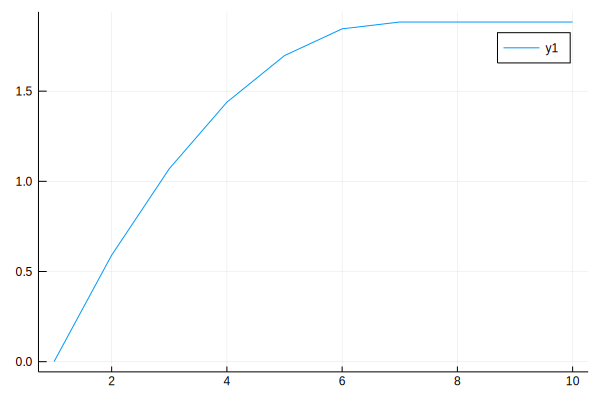

In [31]:
plot(traj[7][1,:])